# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [6]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

Number of observations is 1119


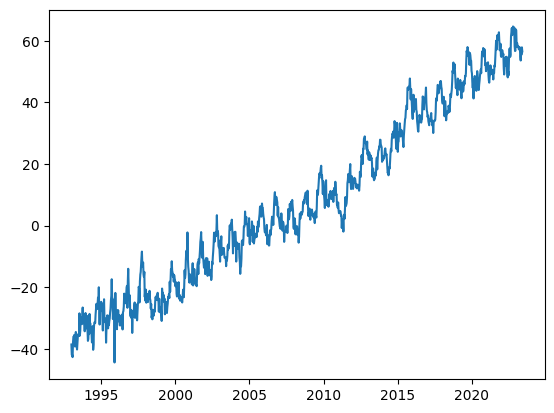

In [7]:
df = pandas.read_csv('sealevel.csv') # loading the data

# plot
plt.plot(np.array(df['Year']),np.array(df['GMSL']))

# print of nr observations
print(f'Number of observations is', len(df))

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:**

We need to remove the trend as we want the time serie to be stationary before fitting the AR model. This is not the case when there is a trend as the mean isnt constant.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

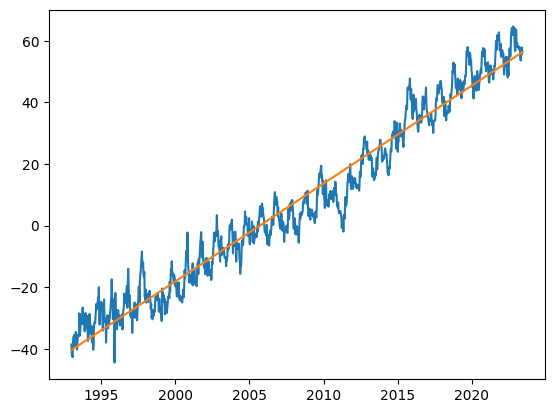

In [8]:
# 1.
year = np.array(df['Year']).reshape(-1,1) # reshapiung
Y = np.array(df['GMSL']).reshape(-1,1)
# fitting linear reg
lmfit = lm.LinearRegression().fit(year, Y)

plt.plot(np.array(df['Year']),np.array(df['GMSL']))
plt.plot(year,lmfit.predict(year))
plt.show()
# removing trend
y = Y - lmfit.predict(year) # removing trend

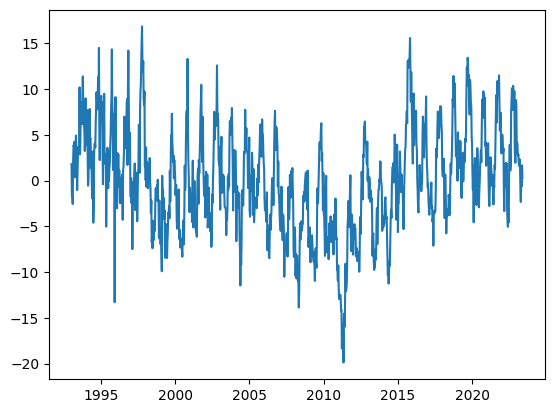

In [9]:
plt.plot(year,y) # ploting y
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

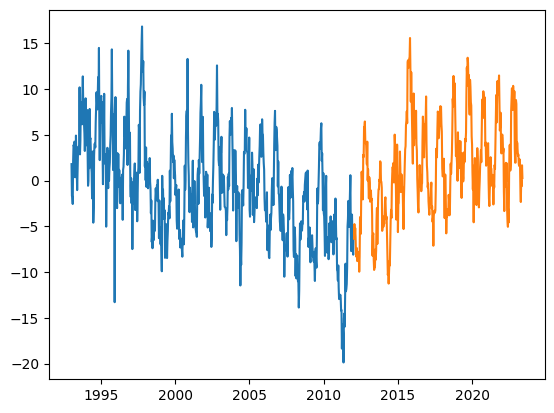

In [10]:
df['y'] = y # adding y to df


train = df[:700] # splitting
val = df[700:]

plt.plot(np.array(train['Year']),np.array(train['y']))
plt.plot(np.array(val['Year']),np.array(val['y']))
plt.show()

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [11]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) # data points in y <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p)) #nxp matrix <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[j:n-p+j] # removing the last p values, then moving them j step(s) per iteration
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [12]:
theta =fit_ar(train['y'],10)
print(theta[::-1])

[ 0.63068183  0.1231388   0.12558768  0.17683292 -0.02284342 -0.07140349
 -0.05693816  0.0479181  -0.0893176   0.0251526 ]


We reverse the thetas so they are in the correct order here, the latest value Yt, affects the prediction the most as 0.63 is the highest value of the parameters. 

**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [13]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        
        y_pred[i] = np.dot(theta, y_target[i:p+i]) # picking out values from i to i+p and doing the dot product
    return y_pred

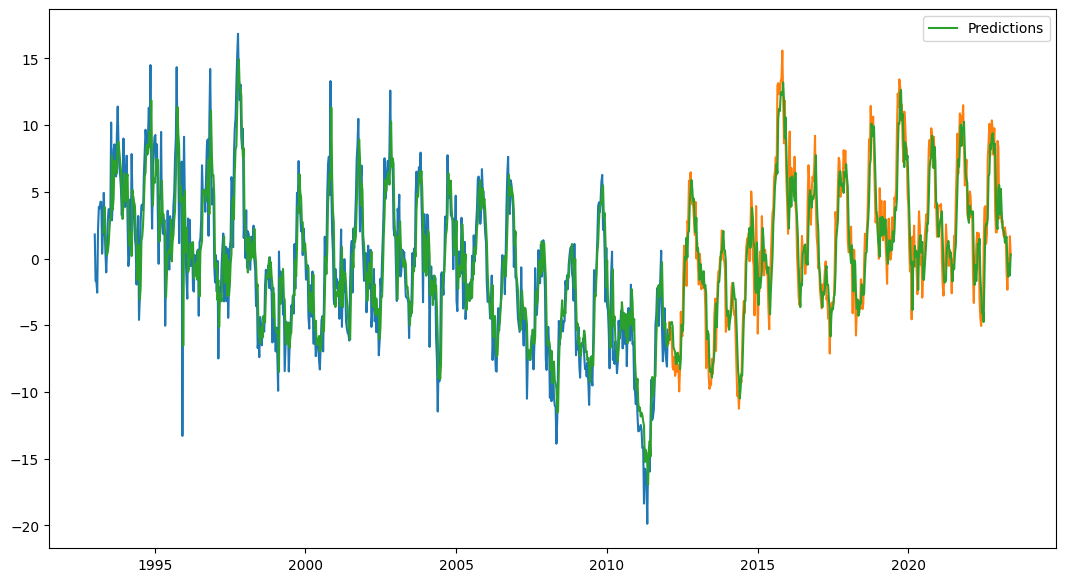

In [14]:
pred = predict_ar_1step(theta,df['y'])

plt.figure(figsize= (13,7)) # changig fig size to be able to see more details
plt.plot(np.array(train['Year']),np.array(train['y']))
plt.plot(np.array(val['Year']),np.array(val['y']))
plt.plot(np.array(df['Year'][10:]),np.array(pred), label='Predictions') # predictions 
plt.legend() # legend
plt.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

In [15]:
help(acfplot)

Help on function acfplot in module tssltools_lab1:

acfplot(x, lags=None, conf=0.95)
    Plots the empirical autocorralation function.
    
    :param x: array (n,), sequence of data points
    :param lags: int, maximum lag to compute the ACF for. If None, this is set to n-1. Default is None.
    :param conf: float, number in the interval [0,1] which specifies the confidence level (based on a central limit
                 theorem under a white noise assumption) for two dashed lines drawn in the plot. Default is 0.95.
    :return:



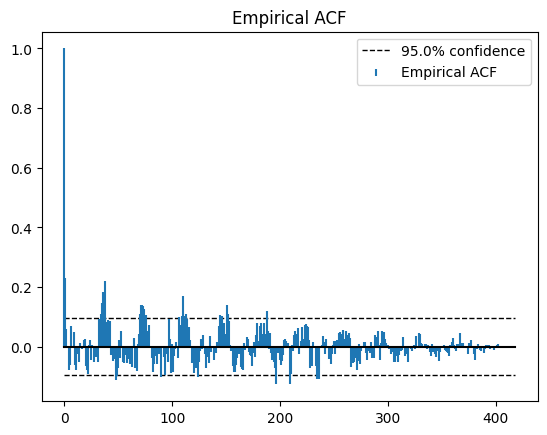

In [16]:
valres = val['y'] - pred[690:] # validation residuals
acfplot(valres)

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [207]:
mod_val = []

def mse(pred, y): # function to get the MSE
    return np.square((pred-y)).mean()
    
# looping over different p values and calculating MSE for the predictions on train and val data
for p in range(2,151): 
    theta = fit_ar(train['y'],p) # get the thetas
    
    # saving the train and val results in a list for each p 
    
    mod_val.append( {'p':p,'train':mse(predict_ar_1step(theta,train['y']), train['y'][p:]), 'val':mse(predict_ar_1step(theta,val['y']),val['y'][p:])})
    


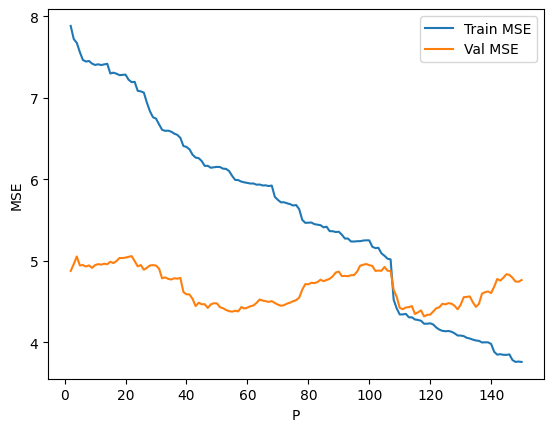

In [208]:
mod_val = pandas.DataFrame(mod_val) # making a df of the list

# plotting train and val vs p
plt.plot(mod_val['p'], mod_val['train'], label='Train MSE')
plt.plot(mod_val['p'], mod_val['val'], label='Val MSE')
plt.legend() 
plt.xlabel("P")
plt.ylabel("MSE")

plt.show()

1. As the value of p increases the training MSE decreases but it doesnt really affect the validation MSE that much(compared to the train MSE). This is because we are learning from the training data, after some values of p the validation MSE even grows but the training MSE still decreases which indicates overfitting.

2. We would chose a p of around 42 as to that point the validation MSE decreases by, according to us, an sufficient amount for each added p. The MSE could be lower for p = 60 or 110-115, but the added complexity doesnt really improve the model that much. 

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

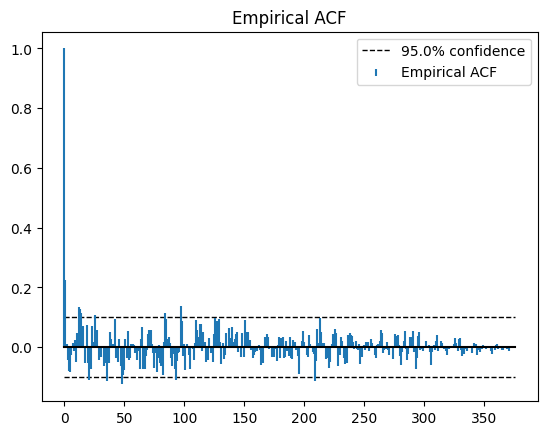

In [21]:
pred42 = predict_ar_1step(fit_ar(train['y'],42),val['y'])
res42 = pred42-val['y'][42:]
acfplot(res42)

There is now much less autocorrelations between the residuals, as the spikes are lower and fewer than for p=10. The model have picked up more of the seasonal pattern from the data now when we are using a more complex model.

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [102]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point

    for i in range(m):
        
        y_sim[i] = np.dot(theta[::-1], phi[:p]) # predicting 1 step for the first p values of phi, flipping theta as its from a_tp:a_t-1 from earlier
        phi = np.insert(phi, 0,y_sim[i], axis=0) # adding the predicted step to phi so it will be used in next prediction
    
    return y_sim
    

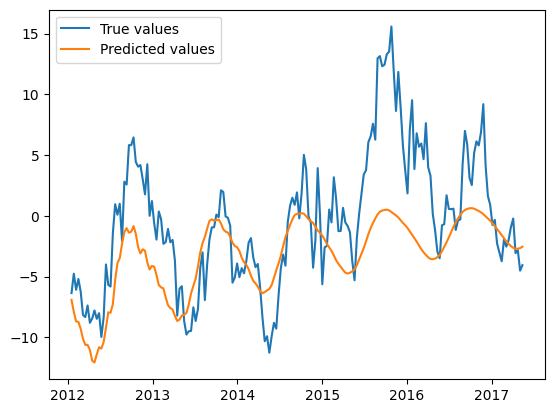

In [103]:

val_pred =simulate_ar(train['y'],fit_ar(train['y'],42),197) # using our p 42 model and the training data to predict 701:997

# plotting 
plt.plot( val['Year'][:197],val['y'][:197], label='True values')
plt.plot(val['Year'][:197],val_pred, label='Predicted values')
plt.legend() 
plt.xlabel("")
plt.ylabel("")

plt.show()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

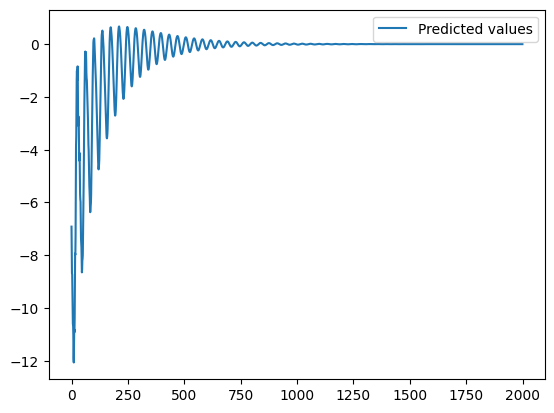

In [104]:
val_pred =simulate_ar(train['y'],fit_ar(train['y'],42),2000) # using our p 42 model and the training data to predict 2000 values

# plotting 
plt.plot(range(2000),val_pred, label='Predicted values')
plt.legend() 
plt.xlabel("")
plt.ylabel("")

plt.show()

As we have stationary data with mean zero, our coefficents will affect our values to decay over time and go towards zero. Meaning that the influence of the past values decrease over time and we end up with only white noise with mean zero. 

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [236]:
p = 42  # lags
tr_df = train.copy() # creating new dataset with lagged variables
for i in range(1, p + 1):
    tr_df[f'y_lag_{i}'] = tr_df['y'].shift(i)

# Drop Nans
tr_df = tr_df.dropna()
# Picking out lagged variables from the df
X_train = tr_df[[f'y_lag_{i}' for i in range(1, p + 1)]].values

# Same thing but on validation data
val_df = val.copy()
for i in range(1, p + 1):
    val_df[f'y_lag_{i}'] = val_df['y'].shift(i)

val_df = val_df.dropna() # dropping nans
# Picking out lagged variables from the df
X_val = val_df[[f'y_lag_{i}' for i in range(1, p + 1)]].values

# 3 hidden layers with 10 nodes, 2k as max iteration
nar = MLPRegressor(hidden_layer_sizes=(10,3),max_iter=2000)

In [237]:
nar_r = nar.fit(X_train,train['y'][p:]) # training the model
nar_pred = nar_r.predict(X_val) # predicting validation data

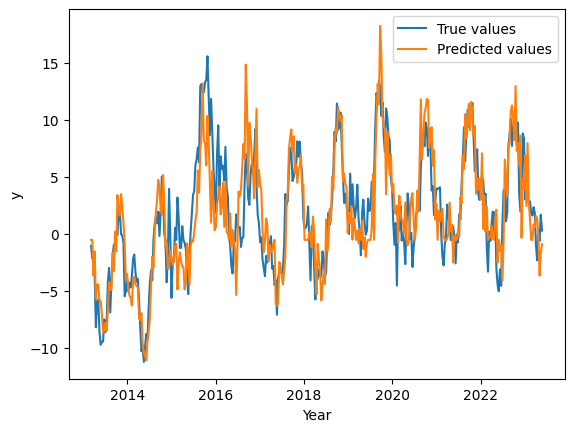

In [238]:

# Plotting
plt.plot(val_df['Year'], val['y'][p:], label='True values')
plt.plot(val_df['Year'], nar_pred, label='Predicted values')
plt.legend()
plt.xlabel("Year")
plt.ylabel("y")
plt.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

In [294]:
# Train the MLP Regressor with 100 nodes and 4 hidden layers, learning rate of 0.01 and logistic/sigmoid as activation func 
nar = MLPRegressor(hidden_layer_sizes=(100,4),max_iter=5000,activation='logistic',learning_rate_init=0.01)
nar_r = nar.fit(X_train, train['y'][p:])

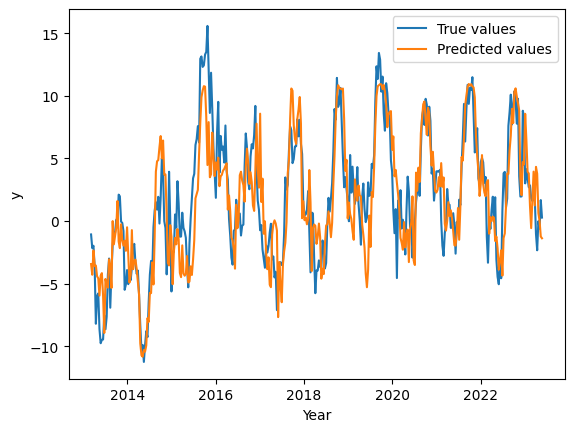

In [295]:
nar_pred = nar_r.predict(X_val) # predicting validation data

# Plotting
plt.plot(val_df['Year'], val['y'][p:], label='True values')
plt.plot(val_df['Year'], nar_pred, label='Predicted values')
plt.legend()
plt.xlabel("Year")
plt.ylabel("y")
plt.show()